#  Visualize Foursquare/Swarm check-in history

  1. Get a Foursquare OAuth token: https://developer.foursquare.com/docs/explore#req=users/self/checkins
  

In [58]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import requests, json
from datetime import datetime as dt

%matplotlib inline
title_fontsize = 14

In [59]:

url_template = 'https://api.foursquare.com/v2/users/self/checkins?limit=250&oauth_token={}&v=20131026&offset={}'

token = "Enter-your-token-here"
offset = 0
data = []
 
with open("checkins.json", 'w') as f:
    while True:
        response = requests.get(url_template.format(token, offset))
        if len(response.json()['response']['checkins']['items']) == 0:
            break

        data.append(response.json())
        offset += 250
            
    f.write(json.dumps(data, indent=2))

## Now parse the responses and load into a dataframe

In [60]:
# location_components is the list of pieces we're interested in pulling out of the dataset
location_components = ['city', 'state', 'country', 'lat', 'lng']
rows = []
for response in data:
    for item in response['response']['checkins']['items']:
        try:
            checkin = {}
            checkin['venue_name'] = item['venue']['name']
            checkin['created_at'] = item['createdAt']
            
            if len(item['venue']['categories']) > 0:
                checkin['category'] = item['venue']['categories'][0]['name']
                
            for component in location_components:
                if component in item['venue']['location']:
                    checkin[component] = item['venue']['location'][component]
                else:
                    checkin[component] = np.nan
            rows.append(checkin)
        except:
            pass

In [61]:
df_full = pd.DataFrame(rows)

# make each column that could contain non-ascii characters unicode
df_full['category'] = df_full['category'].astype(unicode)
df_full['city'] = df_full['city'].astype(unicode)
df_full['state'] = df_full['state'].astype(unicode)

# convert unix timestamp to date and time, then drop the timestamp column
df_full['datetime'] = df_full['created_at'].map(lambda x: dt.fromtimestamp(x).strftime('%Y-%m-%d %H:%M'))
df_full = df_full.drop('created_at', axis=1)

# rename lng column to lon
df_full = df_full.rename(columns={'lng':'lon'})

In [62]:
# remove health care and private homes for privacy purposes
terms = ['doctor', 'emergency', 'urgent', 'hospital', 'medical', 'private']
mask = False
for term in terms:
    mask = mask | df_full['category'].str.lower().str.contains(term)
    
df_filtered = df_full[~mask].copy()

## Visualize the check-in data

In [63]:
# create day/hour/month columns for time series visualization
df_filtered['weekday'] = df_filtered['datetime'].map(lambda x: dt.strptime(x, '%Y-%m-%d %H:%M').weekday())
df_filtered['hour'] = df_filtered['datetime'].map(lambda x: dt.strptime(x, '%Y-%m-%d %H:%M').hour)
df_filtered['month'] = df_filtered['datetime'].str[0:7]

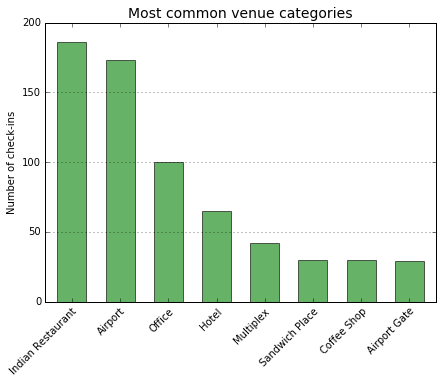

In [64]:
# most common venue categories
countdata = df_filtered['category'].value_counts().head(8)
ax = countdata.plot(kind='bar', figsize=[7, 5], width=0.6, alpha=0.6, 
                    color='g', edgecolor='k', grid=False)
ax.set_xticklabels(countdata.index, rotation=45, rotation_mode='anchor', ha='right')
ax.yaxis.grid(True)
ax.set_title('Most common venue categories', fontsize=title_fontsize)
ax.set_ylabel('Number of check-ins')

plt.savefig('images/foursquare_common_categories.png', dpi=96, bbox_inches='tight')
plt.show()

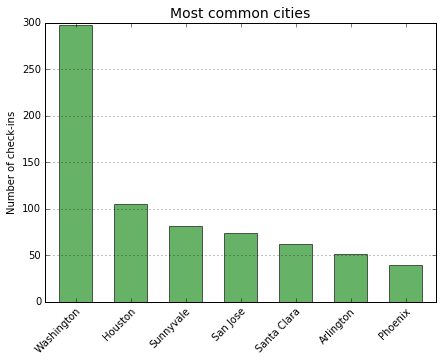

In [65]:
# most common cities (and drop N/A)
countdata = df_filtered['city'].value_counts().head(8)
countdata = countdata.drop('nan', axis=0)
ax = countdata.plot(kind='bar', figsize=[7, 5], width=0.6, alpha=0.6, 
                    color='g', edgecolor='k', grid=False)
ax.set_xticklabels(countdata.index, rotation=45, rotation_mode='anchor', ha='right')
ax.yaxis.grid(True)
ax.set_title('Most common cities', fontsize=title_fontsize)
ax.set_ylabel('Number of check-ins')

plt.savefig('images/foursquare_common_cities.png', dpi=96, bbox_inches='tight')
plt.show()

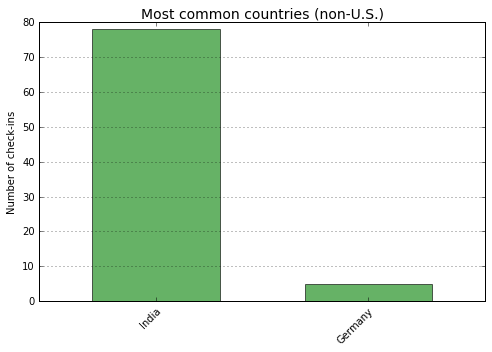

In [66]:
# most common countries, other than the US
countdata = df_filtered['country'].value_counts().iloc[1:12]
ax = countdata.plot(kind='bar', figsize=[8, 5], width=0.6, alpha=0.6, 
                    color='g', edgecolor='k', grid=False)
ax.set_xticklabels(countdata.index, rotation=45, rotation_mode='anchor', ha='right')
ax.yaxis.grid(True)
ax.set_title('Most common countries (non-U.S.)', fontsize=title_fontsize)
ax.set_ylabel('Number of check-ins')

plt.savefig('images/foursquare_common_countries.png', dpi=96, bbox_inches='tight')
plt.show()

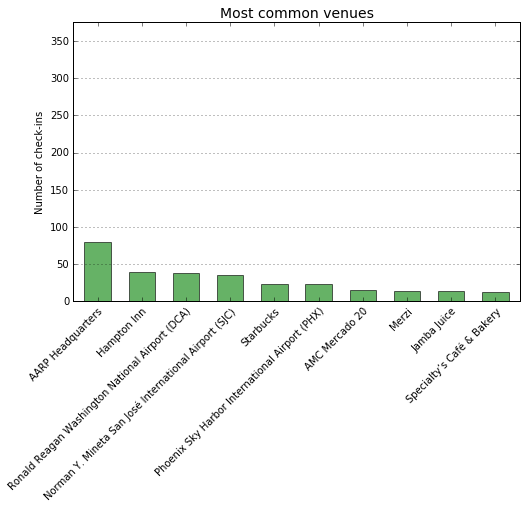

In [67]:
# venues with the most check-ins
df_filtered['venue_name'] = df_filtered['venue_name'].str.replace('Hampton Inn Convention Center', 'Hampton Inn')
countdata = df_filtered['venue_name'].value_counts().head(10)
ax = countdata.plot(kind='bar', figsize=[8, 5], width=0.6, alpha=0.6, 
                    color='g', edgecolor='k', grid=False)
ax.set_xticklabels(countdata.index, rotation=45, rotation_mode='anchor', ha='right')
ax.set_ylim(0, 375)
ax.yaxis.grid(True)
ax.set_title('Most common venues', fontsize=title_fontsize)
ax.set_ylabel('Number of check-ins')

plt.savefig('images/foursquare_common_venues.png', dpi=96, bbox_inches='tight')
plt.show()

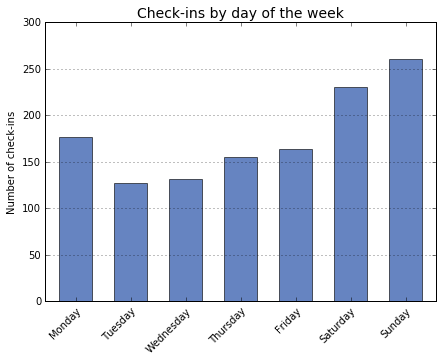

In [68]:
# check-ins by the day of the week
countdata = df_filtered.groupby('weekday')['weekday'].count()
countdata.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = countdata.plot(kind='bar', figsize=[7, 5], width=0.6, alpha=0.6, 
                    color='#003399', edgecolor='k', grid=False)
ax.set_xticklabels(countdata.index, rotation=45, rotation_mode='anchor', ha='right')
ax.yaxis.grid(True)
ax.set_title('Check-ins by day of the week', fontsize=title_fontsize)
ax.set_ylabel('Number of check-ins')

plt.savefig('images/foursquare_checkins_weekday.png', dpi=96, bbox_inches='tight')
plt.show()

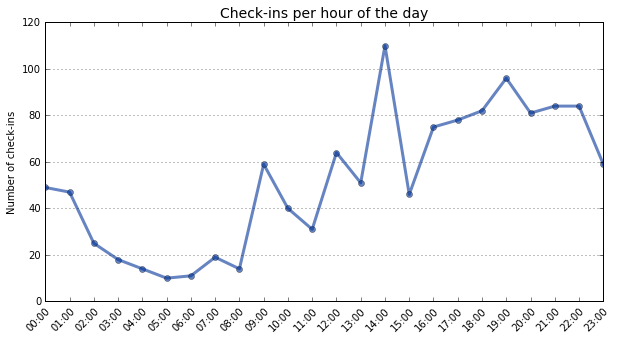

In [69]:
# check-ins by the hour of the day
countdata = df_filtered.groupby('hour')['hour'].count()
xlabels = ['{:02}:00'.format(x) for x in countdata.index]
ax = countdata.plot(kind='line',
                    figsize=[10, 5],
                    linewidth='3', 
                    alpha=0.6,
                    marker='o',
                    color='#003399')
ax.yaxis.grid(True)
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right')
ax.set_ylabel('Number of check-ins')
ax.set_xlabel('')
ax.set_title('Check-ins per hour of the day', fontsize=title_fontsize)

plt.savefig('images/foursquare_checkins_hour.png', dpi=96, bbox_inches='tight')
plt.show()

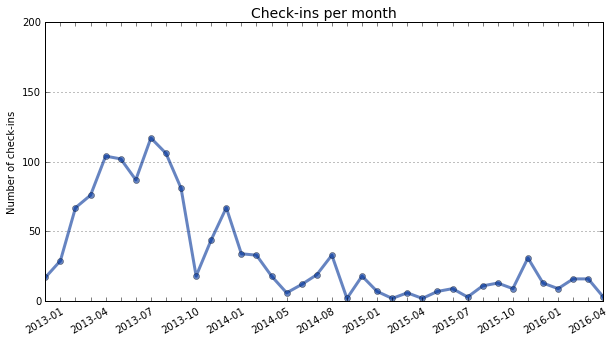

In [70]:
# check-ins by month
countdata = df_filtered.groupby('month')['month'].count()
xlabels = countdata.iloc[range(1, len(countdata), 3)].index
xlabels = [x if x in xlabels else '' for x in countdata.index]
ax = countdata.plot(kind='line',
                    figsize=[10, 5],
                    linewidth='3', 
                    alpha=0.6,
                    marker='o',
                    color='#003399')
ax.yaxis.grid(True)
ax.set_ylim([0,200])
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=30, rotation_mode='anchor', ha='right')
ax.set_ylabel('Number of check-ins')
ax.set_xlabel('')
ax.set_title('Check-ins per month', fontsize=title_fontsize)

plt.savefig('images/foursquare_checkins_month.png', dpi=96, bbox_inches='tight')
plt.show()